In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import of libraries

In [2]:
import os
import numpy as np
import pandas as pd 

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt 
from pandas.plotting import scatter_matrix

# Scalers
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Data processing, evaluation and model selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

# Metrics
from sklearn.metrics import mean_squared_error, confusion_matrix, plot_confusion_matrix,
from sklearn.metrics import roc_auc_score, classification_report 

# Classification libraries
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

# XGBoost
import xgboost as xgb

## Plotting settings

In [3]:
# Notebook style plotting
%matplotlib notebook

# Fefault colourpalette
color_paletten = sns.color_palette()

# Set theme for plotting with seaborn
theme = sns.set_theme(style='whitegrid', palette=color_paletten)

## Import of data

In [4]:
# Change directory
os.chdir('/kaggle/input/nasa-asteroids-classification/')

In [5]:
# Read .csv file into DataFrame
datan = pd.read_csv('nasa.csv')

## Data exploration

In [6]:
datan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neo Reference ID              4687 non-null   int64  
 1   Name                          4687 non-null   int64  
 2   Absolute Magnitude            4687 non-null   float64
 3   Est Dia in KM(min)            4687 non-null   float64
 4   Est Dia in KM(max)            4687 non-null   float64
 5   Est Dia in M(min)             4687 non-null   float64
 6   Est Dia in M(max)             4687 non-null   float64
 7   Est Dia in Miles(min)         4687 non-null   float64
 8   Est Dia in Miles(max)         4687 non-null   float64
 9   Est Dia in Feet(min)          4687 non-null   float64
 10  Est Dia in Feet(max)          4687 non-null   float64
 11  Close Approach Date           4687 non-null   object 
 12  Epoch Date Close Approach     4687 non-null   int64  
 13  Rel

In [7]:
print(datan.isnull().sum())

Neo Reference ID                0
Name                            0
Absolute Magnitude              0
Est Dia in KM(min)              0
Est Dia in KM(max)              0
Est Dia in M(min)               0
Est Dia in M(max)               0
Est Dia in Miles(min)           0
Est Dia in Miles(max)           0
Est Dia in Feet(min)            0
Est Dia in Feet(max)            0
Close Approach Date             0
Epoch Date Close Approach       0
Relative Velocity km per sec    0
Relative Velocity km per hr     0
Miles per hour                  0
Miss Dist.(Astronomical)        0
Miss Dist.(lunar)               0
Miss Dist.(kilometers)          0
Miss Dist.(miles)               0
Orbiting Body                   0
Orbit ID                        0
Orbit Determination Date        0
Orbit Uncertainity              0
Minimum Orbit Intersection      0
Jupiter Tisserand Invariant     0
Epoch Osculation                0
Eccentricity                    0
Semi Major Axis                 0
Inclination   

In [8]:
datan.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [9]:
datan.describe()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion
count,4.687000e+03,4.687000e+03,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,...,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4.687000e+03,4687.000000,4687.000000
mean,3.272298e+06,3.272298e+06,22.267865,0.204604,0.457509,204.604203,457.508906,0.127135,0.284283,671.273653,...,1.400264,13.373844,172.157275,635.582076,0.813383,183.932151,1.987144,2.457728e+06,181.167927,0.738242
std,5.486011e+05,5.486011e+05,2.890972,0.369573,0.826391,369.573402,826.391249,0.229642,0.513496,1212.511199,...,0.524154,10.936227,103.276777,370.954727,0.242059,103.513035,0.951519,9.442264e+02,107.501623,0.342627
min,2.000433e+06,2.000433e+06,11.160000,0.001011,0.002260,1.010543,2.259644,0.000628,0.001404,3.315431,...,0.615920,0.014513,0.001941,176.557161,0.080744,0.006918,0.803765,2.450100e+06,0.003191,0.086285
25%,3.097594e+06,3.097594e+06,20.100000,0.033462,0.074824,33.462237,74.823838,0.020792,0.046493,109.784247,...,1.000635,4.962341,83.081208,365.605031,0.630834,95.625916,1.266059,2.457815e+06,87.006918,0.453289
50%,3.514799e+06,3.514799e+06,21.900000,0.110804,0.247765,110.803882,247.765013,0.068850,0.153954,363.529809,...,1.240981,10.311836,172.625393,504.947292,0.833153,189.761641,1.618195,2.457973e+06,185.718889,0.712946
75%,3.690060e+06,3.690060e+06,24.500000,0.253837,0.567597,253.837029,567.596853,0.157727,0.352688,832.798679,...,1.678364,19.511681,255.026909,794.195972,0.997227,271.777557,2.451171,2.458108e+06,276.531946,0.984669
max,3.781897e+06,3.781897e+06,32.100000,15.579552,34.836938,15579.552413,34836.938254,9.680682,21.646663,51114.018738,...,5.072008,75.406667,359.905890,4172.231343,1.299832,359.993098,8.983852,2.458839e+06,359.917991,2.039000


In [10]:
datan['Hazardous'].describe()

count      4687
unique        2
top       False
freq       3932
Name: Hazardous, dtype: object

In [11]:
datan.nunique()

Neo Reference ID                3692
Name                            3692
Absolute Magnitude               269
Est Dia in KM(min)               269
Est Dia in KM(max)               269
Est Dia in M(min)                269
Est Dia in M(max)                269
Est Dia in Miles(min)            269
Est Dia in Miles(max)            269
Est Dia in Feet(min)             269
Est Dia in Feet(max)             269
Close Approach Date              777
Epoch Date Close Approach        777
Relative Velocity km per sec    4687
Relative Velocity km per hr     4687
Miles per hour                  4687
Miss Dist.(Astronomical)        4673
Miss Dist.(lunar)               4660
Miss Dist.(kilometers)          4661
Miss Dist.(miles)               4660
Orbiting Body                      1
Orbit ID                         188
Orbit Determination Date        2680
Orbit Uncertainity                10
Minimum Orbit Intersection      3678
Jupiter Tisserand Invariant     2495
Epoch Osculation                 429
E

In [12]:
datan['Orbiting Body'].unique()

array(['Earth'], dtype=object)

In [13]:
datan['Equinox'].unique()

array(['J2000'], dtype=object)

In [14]:
datan['Close Approach Date'].unique()

array(['1995-01-01', '1995-01-08', '1995-01-15', '1995-01-22',
       '1995-02-08', '1995-02-15', '1995-02-22', '1995-03-08',
       '1995-03-15', '1995-03-22', '1995-04-08', '1995-04-15',
       '1995-04-22', '1995-05-08', '1995-05-15', '1995-05-22',
       '1995-06-08', '1995-06-15', '1995-06-22', '1995-07-08',
       '1995-07-15', '1995-07-22', '1995-08-08', '1995-08-15',
       '1995-08-22', '1995-09-08', '1995-09-15', '1995-09-22',
       '1995-10-08', '1995-10-15', '1995-10-22', '1995-11-08',
       '1995-11-15', '1995-11-22', '1995-12-08', '1995-12-15',
       '1995-12-22', '1996-01-08', '1996-01-15', '1996-01-22',
       '1996-02-08', '1996-02-15', '1996-02-22', '1996-03-08',
       '1996-03-22', '1996-04-08', '1996-04-15', '1996-04-22',
       '1996-05-08', '1996-05-15', '1996-05-22', '1996-06-08',
       '1996-06-15', '1996-06-22', '1996-07-08', '1996-07-15',
       '1996-07-22', '1996-08-08', '1996-08-15', '1996-08-22',
       '1996-09-08', '1996-09-15', '1996-09-22', '1996-

In [15]:
datan['Orbit Determination Date'].unique()

array(['2017-04-06 08:36:37', '2017-04-06 08:32:49',
       '2017-04-06 09:20:19', ..., '2017-04-06 08:23:43',
       '2017-04-06 08:23:42', '2017-04-29 06:18:33'], dtype=object)

## Selection of features

### Dropping redundant features

In [16]:
# Neo Reference ID and Name are redundant as identifier, drop Name, set Neo Reference ID as index
datan.set_index(['Neo Reference ID'], drop=True)
datan.drop(['Name'], axis=1, inplace=True)

In [17]:
# Orbiting Body and Equinox are the same for all rows, does not provide any information and can be dropped
datan.drop(['Orbiting Body'], axis=1, inplace=True)
datan.drop(['Equinox'], axis=1, inplace=True)

In [18]:
# Close Approach Date and Orbit Determination Date are difficult to handle as numerical data, dropped
datan.drop(['Close Approach Date'], axis=1, inplace=True)
datan.drop(['Orbit Determination Date'], axis=1, inplace=True)

In [19]:
# Estimated Min and Max Diamater in kilometer, meter, miles and feet. These are redundant and only one unit is needed.
# Keeping Min and Max Diameter in meter, while droppping the others.

datan.drop(['Est Dia in KM(min)'], axis=1, inplace=True)
datan.drop(['Est Dia in KM(max)'], axis=1, inplace=True)
datan.drop(['Est Dia in Miles(min)'], axis=1, inplace=True)
datan.drop(['Est Dia in Miles(max)'], axis=1, inplace=True)
datan.drop(['Est Dia in Feet(min)'], axis=1, inplace=True)
datan.drop(['Est Dia in Feet(max)'], axis=1, inplace=True)

In [20]:
# Relative Velocity km per sec and hour, and Miles per hour redundant, choosing to keep Km/Sec, dropping other.
datan.drop(['Relative Velocity km per hr'], axis=1, inplace=True)
datan.drop(['Miles per hour'], axis=1, inplace=True)

In [21]:
# Miss Dist in units: (Astronomical), (lunar), (kilometers), (miles). 
# Not exact same number of unique values ( and the unique values might not be the same),
# So not redundant, but number of unique values similar, For this choosing to keep the unit with most unique values:
# (Astronomical), while dropping the other.
datan.drop(['Miss Dist.(lunar)'], axis=1, inplace=True)
datan.drop(['Miss Dist.(kilometers)'], axis=1, inplace=True)
datan.drop(['Miss Dist.(miles)'], axis=1, inplace=True)

In [22]:
# Reset index and set as Neo Reference ID again
datan.reset_index(drop=True)
datan.set_index('Neo Reference ID', inplace=True)

### Selection of X

In [23]:
# Dropping column with labels, rest of columns as features in X
X = datan.drop(['Hazardous'], axis=1)
print(X.columns)
X.head()

Index(['Absolute Magnitude', 'Est Dia in M(min)', 'Est Dia in M(max)',
       'Epoch Date Close Approach', 'Relative Velocity km per sec',
       'Miss Dist.(Astronomical)', 'Orbit ID', 'Orbit Uncertainity',
       'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant',
       'Epoch Osculation', 'Eccentricity', 'Semi Major Axis', 'Inclination',
       'Asc Node Longitude', 'Orbital Period', 'Perihelion Distance',
       'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly',
       'Mean Motion'],
      dtype='object')


,Absolute Magnitude,Est Dia in M(min),Est Dia in M(max),Epoch Date Close Approach,Relative Velocity km per sec,Miss Dist.(Astronomical),Orbit ID,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,...,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion
Neo Reference ID,,,,,,,,,,,,,,,,,,,,,
3703080,21.6,127.219879,284.472297,788947200000,6.115834,0.419483,17,5,0.025282,4.634,...,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551
3723955,21.3,146.067964,326.617897,788947200000,18.113985,0.383014,21,3,0.186935,5.457,...,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330
2446862,20.3,231.502122,517.654482,789552000000,7.590711,0.050956,22,0,0.043058,4.557,...,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371
3092506,27.4,8.801465,19.680675,790156800000,11.173874,0.285322,7,6,0.005512,5.093,...,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277
3514799,21.6,127.219879,284.472297,790156800000,9.840831,0.407832,25,1,0.034798,5.154,...,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395


### Selection of y

In [24]:
# Selection of column with labels to y
y = datan['Hazardous']
le = LabelEncoder()
y = le.fit_transform(y=y)
y

array([1, 0, 1, ..., 0, 0, 0])

## Visualisation - data exploration

### Histograms of features in X

<IPython.core.display.Javascript object>


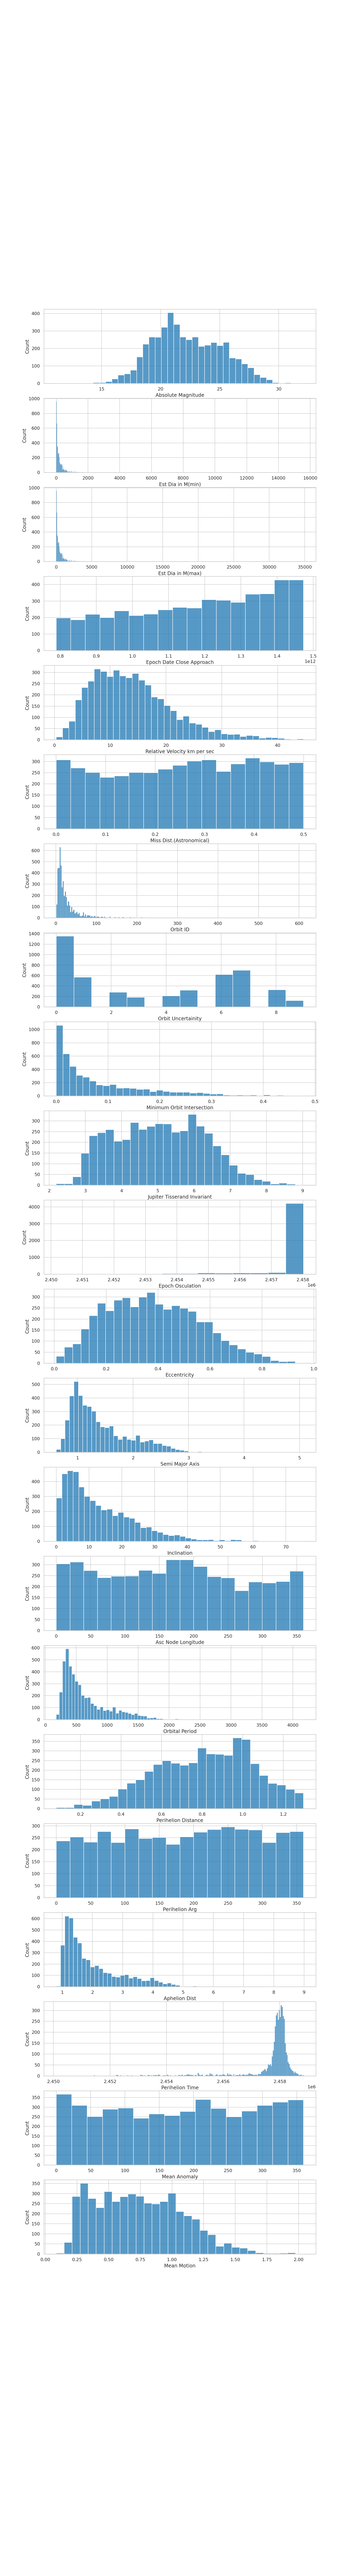

In [25]:
column_count = X.shape[1]

fig, axes = plt.subplots(column_count,1, figsize=(12, 4*column_count))

for (features, colname) in enumerate(X):
    sns.histplot(ax=axes[features], x=colname, data=X)

In [29]:
#grid = sns.PairGrid(data=datan, height = 0.4)

# Map different plots to different sections
#grid = grid.map_upper(sns.pointplot, color = 'darkblue')
#grid = grid.map_lower(sns.kdeplot, cmap = 'Blues', fill=True)
#grid = grid.map_diag(plt.hist, bins = 10, color = 'darkblue', edgecolor = 'b')

### Correlation plot of LINEAR correlations of all used data

<IPython.core.display.Javascript object>


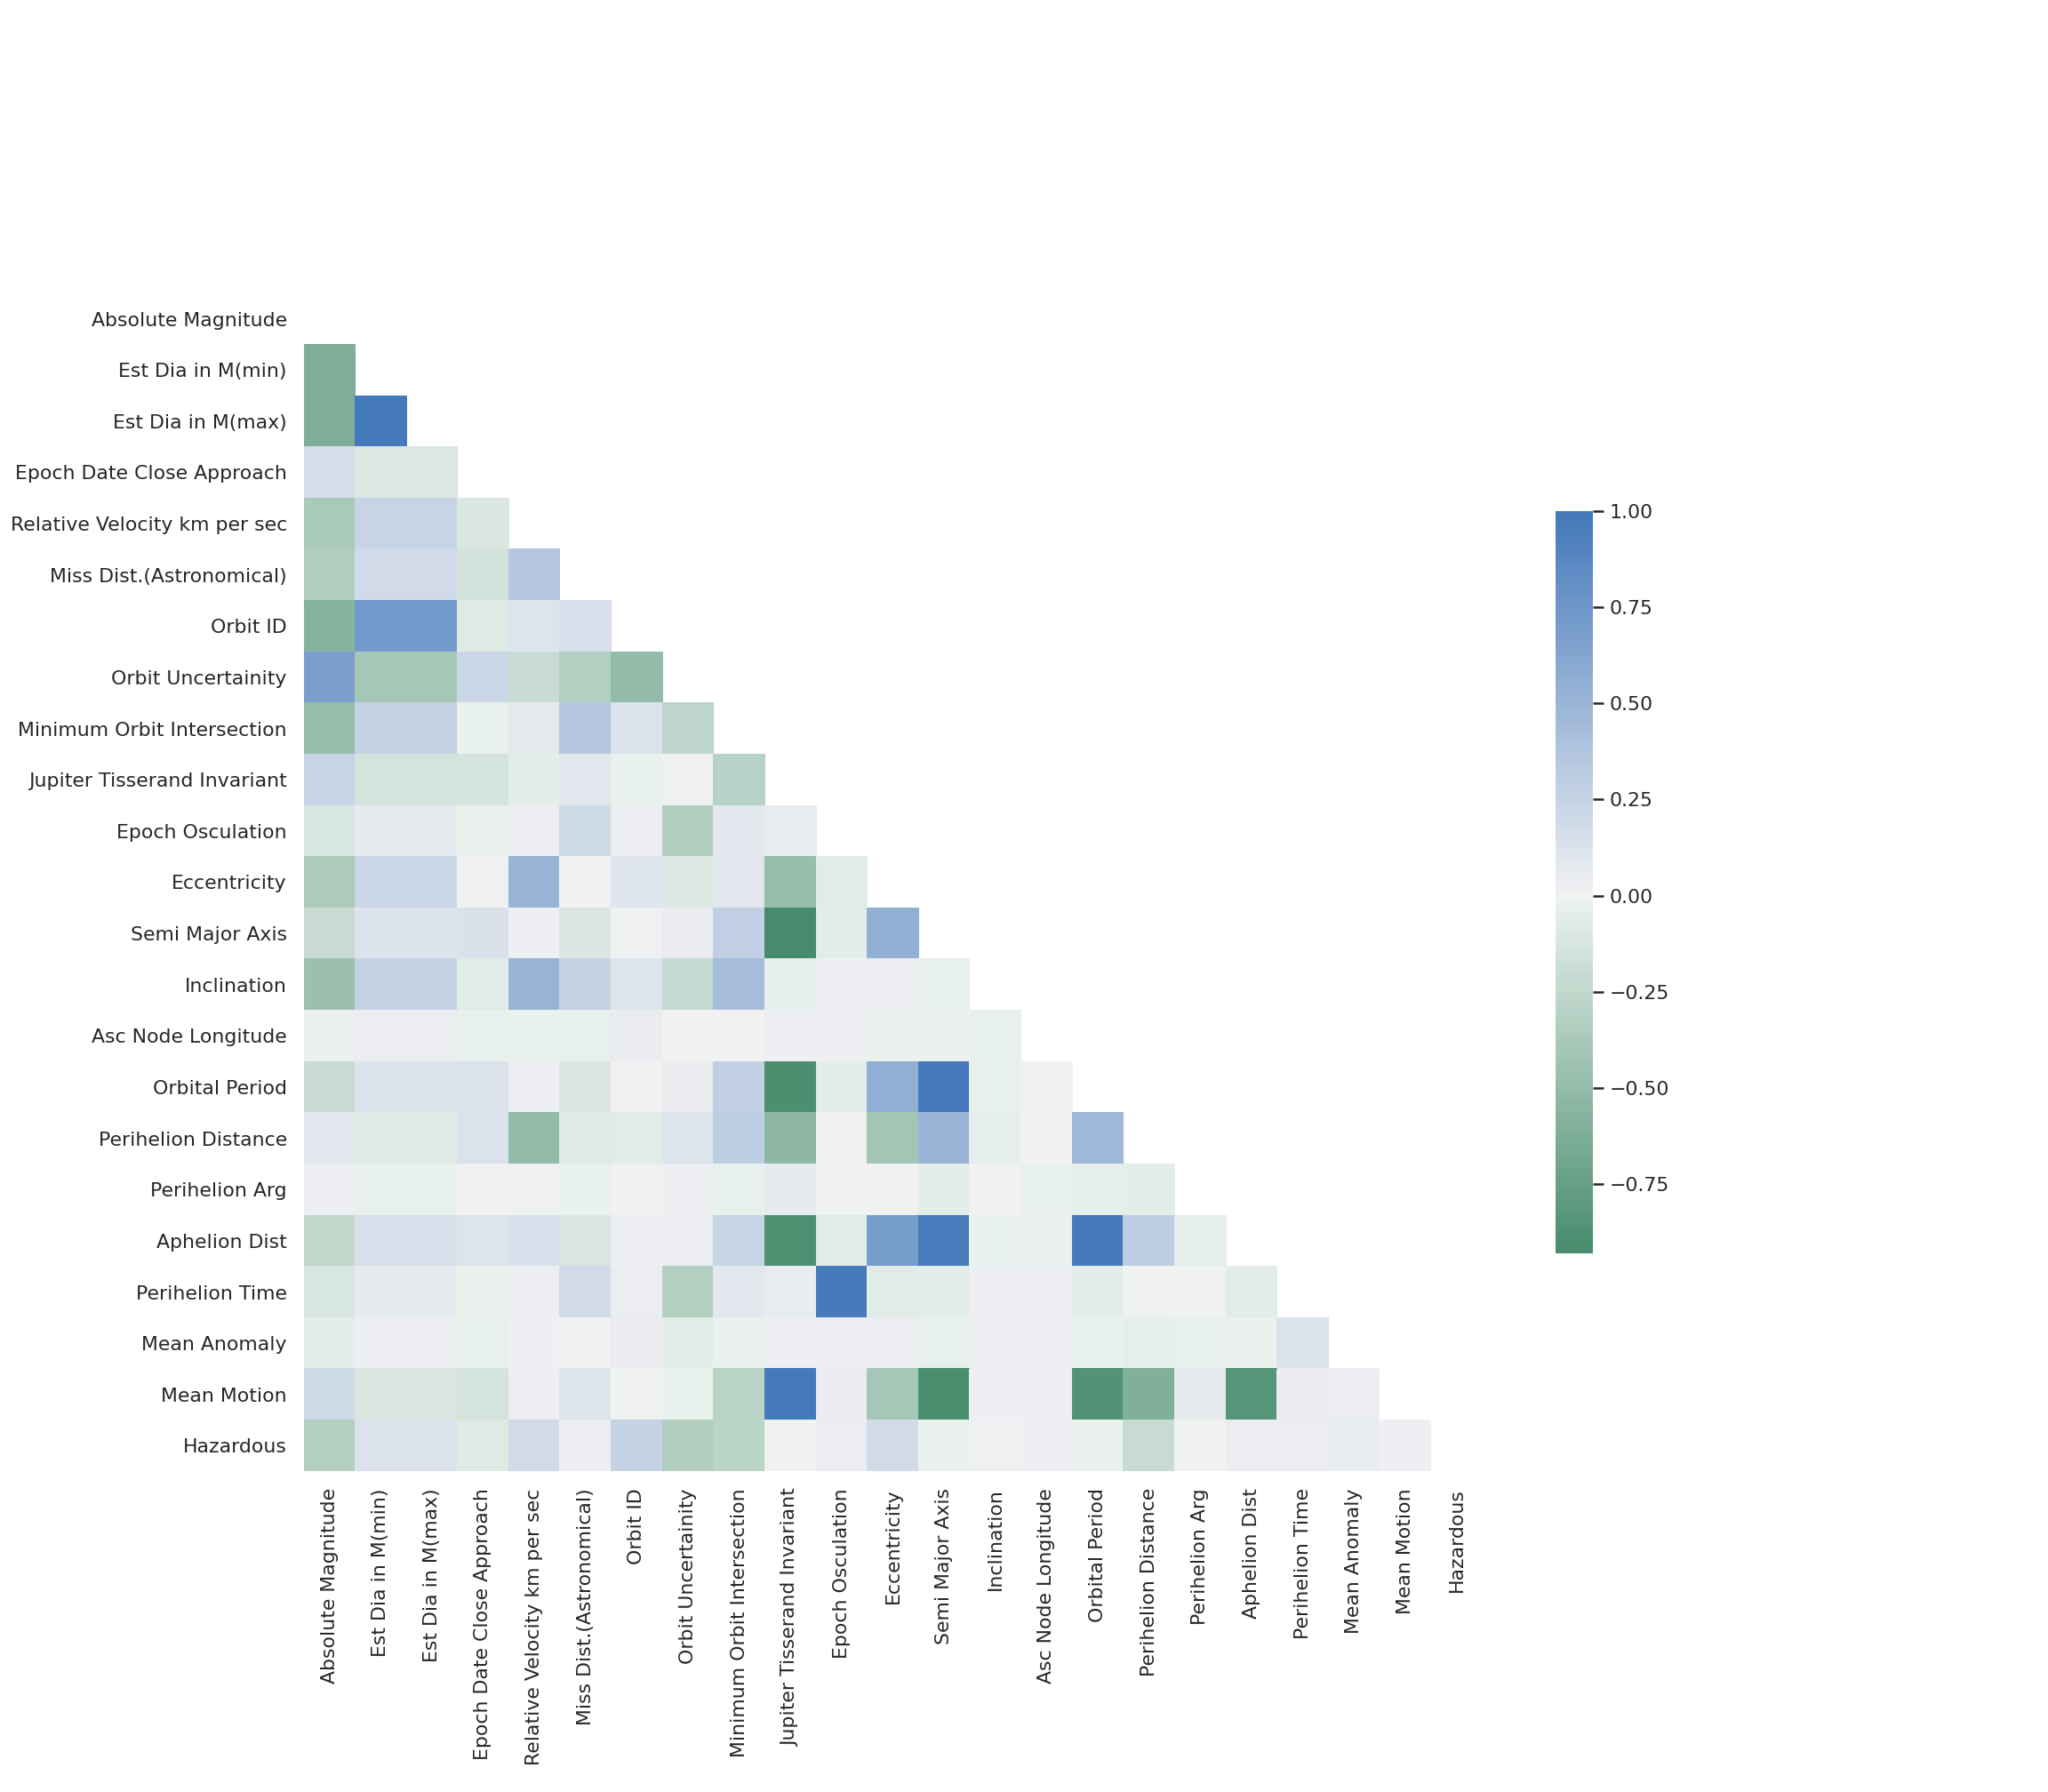

<AxesSubplot:>

In [30]:
corr = datan.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, axes = plt.subplots(figsize=(16, 14))
fig.tight_layout(pad=12)

colormap = sns.diverging_palette(150, 250, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=colormap, vmax=1.0, center=0,
            square=True, cbar_kws={"shrink": .6})

# Classification

## Pre-processing

### Parameters

In [31]:
# How to select data for k-folds cross-validation
kfold = KFold(n_splits=10, shuffle=True)

#from sklearn.utils.class_weight import compute_class_weight
#classes = np.unique(y)
#weight_unbal = compute_class_weight(class_weight = 'balanced', classes = classes, y=y)
#weight_unbal

### Splitting of data into train and test sets

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

### Creating Objects of scalers

In [280]:
scaler_mm_X = MinMaxScaler()
#scaler_mm_y = MinMaxScaler()

scaler_ss_X = StandardScaler()
#scaler_ss_y = StandardScaler()

### Min-max normalization

In [281]:
X_train_n = scaler_mm_X.fit_transform(X_train)
#y_train_n = scaler_mm_y.fit_transform(y_train.reshape(-1, 1))
X_test_n = scaler_mm_X.transform(X_test)
#y_test_n = scaler_mm_y.transform(y_test.reshape(-1, 1))

#y_train_n = y_train_n.ravel()
#y_test_n = y_test_n.ravel()

### Z-score Normalization

In [282]:
X_train_s = scaler_ss_X.fit_transform(X_train)
#y_train_s = scaler_ss_y.fit_transform(y_train.reshape(-1, 1))
X_test_s = scaler_ss_X.transform(X_test)
#y_test_s = scaler_ss_y.transform(y_test.reshape(-1, 1))

#y_train_s = y_train_s.ravel()
#y_test_s = y_test_s.ravel()

## Train and Evaluate models

### Naive Bayes classification

#### Fit on training data and predict on test data

In [283]:
#nb_classifier = CategoricalNB()

#nb_classifier.fit(X_train, y_train)

#y_hat_nb = nb_classifier.predict(X_test)

# !Failed due to not enough memory available

#### Classification report

In [284]:
#class_report = classification_report(y_test, y_hat_knn, output_dict=True)
#pd.DataFrame(class_report)

#### Confusion matrix

In [285]:
#plt.rcParams['figure.figsize'] = [6, 6]

#fig, ax = plt.subplots()

#cm = confusion_matrix(y_test, y_hat_nb)

#sns.heatmap(cm, annot=True, cmap='Blues', fmt='d'); 

#ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
#ax.set_title('Confusion Matrix'); 
#ax.xaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']); ax.yaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']);

#plt.show()

#### Cross-validation

In [286]:
#nb_score = cross_val_score(nb_classifier, X_test, y_test, cv=kfold, scoring = 'f1_weighted')
#nb_scores = nb_score.mean()
#nb_scores

### K-nearest neighbors Classification

#### Fit on training data and predict on test data

In [287]:
n_neigh = 3

knn_classifier = KNeighborsClassifier(n_neighbors = n_neigh)

knn_classifier.fit(X_train_n, y_train)

y_hat_knn = knn_classifier.predict(X_test_n)

#### Classification report

In [288]:
class_report = classification_report(y_test, y_hat_knn, output_dict=True)
pd.DataFrame(class_report)

,0,1,accuracy,macro avg,weighted avg
precision,0.916667,0.609091,0.880597,0.762879,0.872071
recall,0.946384,0.492647,0.880597,0.719516,0.880597
f1-score,0.931288,0.544715,0.880597,0.738002,0.875239
support,802.000000,136.000000,0.880597,938.000000,938.000000


#### Confusion matrix

<IPython.core.display.Javascript object>


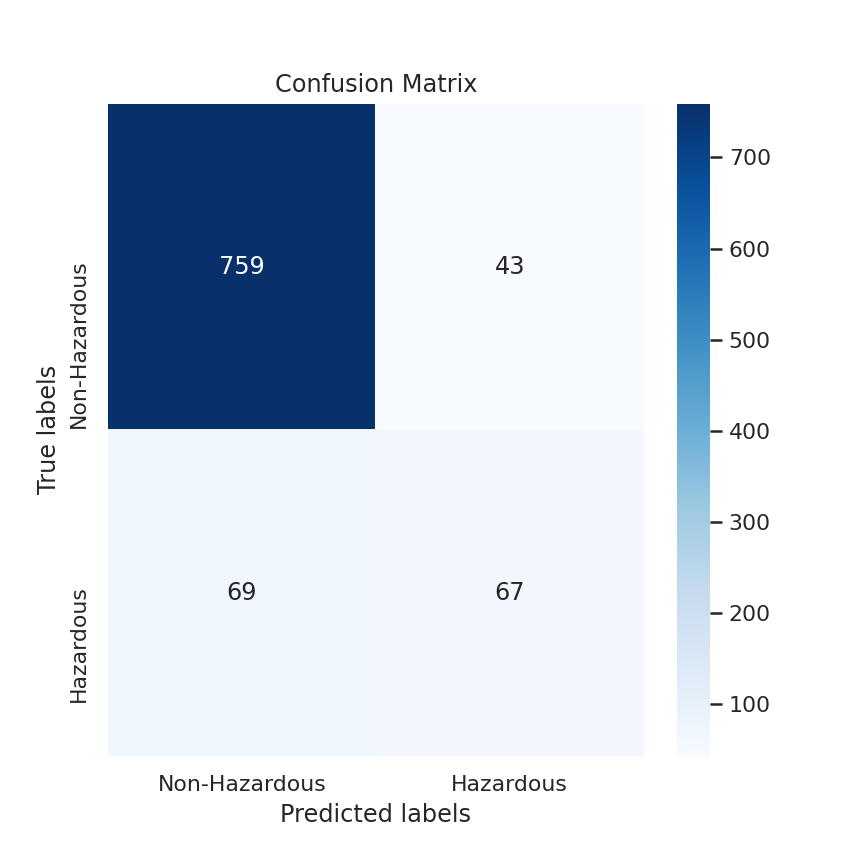

In [289]:
plt.rcParams['figure.figsize'] = [6, 6]

fig, ax = plt.subplots()

cm = confusion_matrix(y_test, y_hat_knn)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d'); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']); ax.yaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']);

plt.show()

#### Cross-validation

In [291]:
knn_score = cross_val_score(knn_classifier, X_train_n, y_train, cv=kfold, scoring='f1_weighted')
knn_scores = knn_score.mean()
knn_scores

0.8701652344508762

### Logistic regression Classification

#### Fit on training data and predict on test data

In [292]:
lr_classifier = LogisticRegression(class_weight='balanced',  max_iter = 200)

lr_classifier.fit(X_train_s, y_train)

y_hat_lr = lr_classifier.predict(X_test_s)

#### Classification report

In [293]:
class_report = classification_report(y_test, y_hat_lr, output_dict=True)
pd.DataFrame(class_report)

,0,1,accuracy,macro avg,weighted avg
precision,0.990642,0.678947,0.927505,0.834795,0.945449
recall,0.923940,0.948529,0.927505,0.936235,0.927505
f1-score,0.956129,0.791411,0.927505,0.873770,0.932247
support,802.000000,136.000000,0.927505,938.000000,938.000000


#### Confusion matrix

<IPython.core.display.Javascript object>


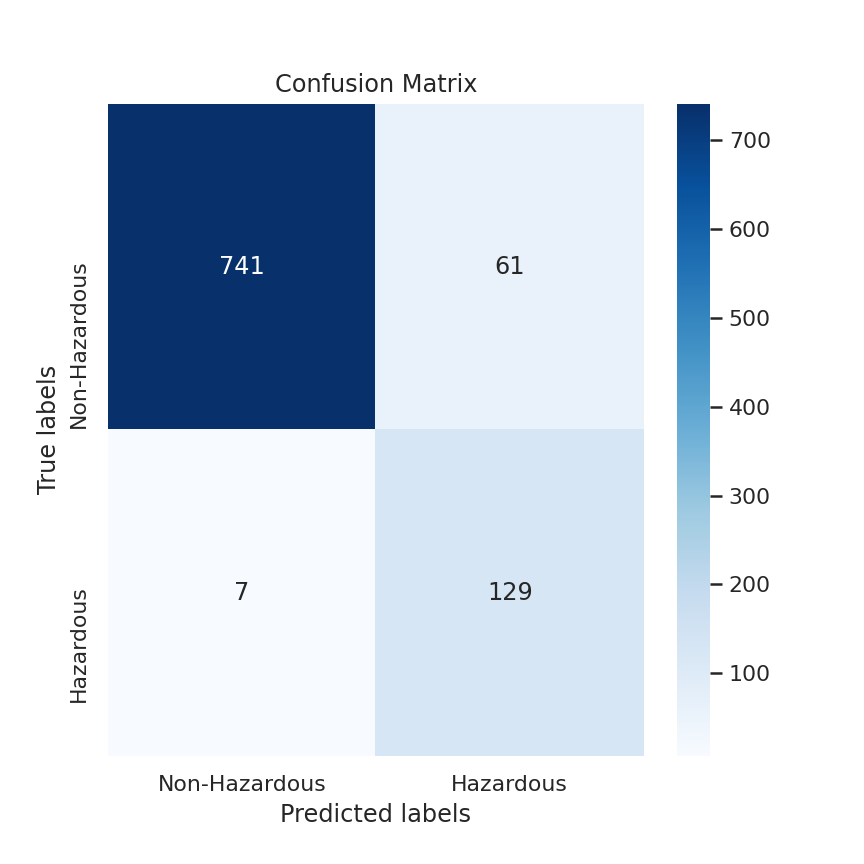

In [294]:
plt.rcParams['figure.figsize'] = [6, 6]

fig, ax = plt.subplots()

cm = confusion_matrix(y_test, y_hat_lr)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d'); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']); ax.yaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']);

plt.show()

#### Cross-validation

In [320]:
lr_score = cross_val_score(lr_classifier, X_train_s, y_train, cv=kfold, scoring='f1_weighted')
lr_scores = lr_score.mean()
lr_scores

0.9361510040464178

### C-support vector Classification

#### Fit on training data and predict on test data

In [321]:
svm_classifier = SVC(class_weight='balanced')

svm_classifier.fit(X_train_s, y_train)

y_hat_svm = svm_classifier.predict(X_test_s)

#### Classification report

In [322]:
class_report = classification_report(y_test, y_hat_svm, output_dict=True)
pd.DataFrame(class_report)

,0,1,accuracy,macro avg,weighted avg
precision,0.990579,0.661538,0.922175,0.826059,0.942871
recall,0.917706,0.948529,0.922175,0.933118,0.922175
f1-score,0.952751,0.779456,0.922175,0.866104,0.927625
support,802.000000,136.000000,0.922175,938.000000,938.000000


#### Confusion matrix

<IPython.core.display.Javascript object>


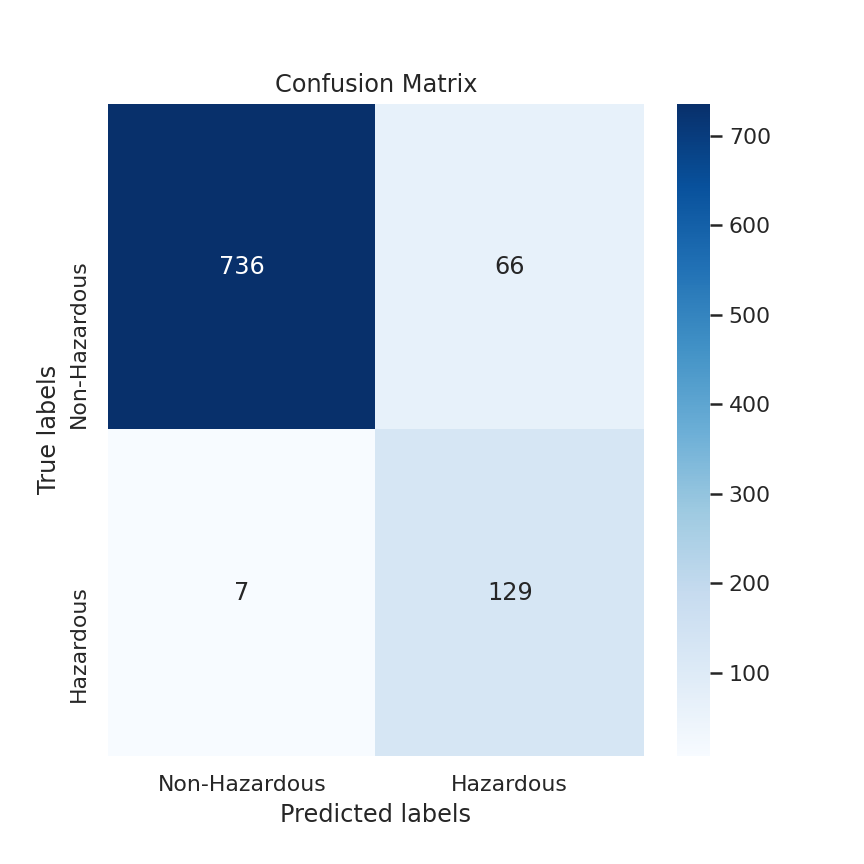

In [298]:
plt.rcParams['figure.figsize'] = [6, 6]

fig, ax = plt.subplots()

cm = confusion_matrix(y_test, y_hat_svm)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d'); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']); ax.yaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']);

plt.show()

#### Cross-validation

In [323]:
svm_score = cross_val_score(svm_classifier, X_train_s, y_train, cv=kfold, scoring='f1_weighted')
svm_scores = svm_score.mean()
svm_scores

0.9245979037411072

### Decision tree Classification

#### Fit on training data and predict on test data

In [324]:
dt_classifier = DecisionTreeClassifier(max_depth = None, class_weight='balanced')
# worse cross-vals score with: class_weight = weight_unbal

dt_classifier.fit(X_train, y_train)

y_hat_dt = dt_classifier.predict(X_test)

#### Classification report

In [325]:
class_report = classification_report(y_test, y_hat_dt, output_dict=True)
pd.DataFrame(class_report)

,0,1,accuracy,macro avg,weighted avg
precision,0.996250,0.963768,0.991471,0.980009,0.991540
recall,0.993766,0.977941,0.991471,0.985853,0.991471
f1-score,0.995006,0.970803,0.991471,0.982905,0.991497
support,802.000000,136.000000,0.991471,938.000000,938.000000


#### Confusion matrix

In [326]:
plt.rcParams['figure.figsize'] = [6, 6]

fig, ax = plt.subplots()

cm = confusion_matrix(y_test, y_hat_dt)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d'); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']); ax.yaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']);

plt.show()

<IPython.core.display.Javascript object>

#### Cross-validation

In [327]:
dt_score = cross_val_score(dt_classifier, X_train, y_train, cv=kfold, scoring='f1_weighted')
dt_scores = dt_score.mean()
dt_scores

0.9935996129040594

### Random forest Classification

#### Fit on training data and predict on test data

In [328]:
rf_classifier = RandomForestClassifier(max_depth = None, n_estimators = 100, class_weight='balanced')

rf_classifier.fit(X_train, y_train)

y_hat_rf = rf_classifier.predict(X_test)

#### Classification report

In [329]:
class_report = classification_report(y_test, y_hat_rf, output_dict=True)
pd.DataFrame(class_report)

,0,1,accuracy,macro avg,weighted avg
precision,0.998753,0.992647,0.997868,0.9957,0.997868
recall,0.998753,0.992647,0.997868,0.9957,0.997868
f1-score,0.998753,0.992647,0.997868,0.9957,0.997868
support,802.000000,136.000000,0.997868,938.0000,938.000000


#### Confusion matrix

In [330]:
plt.rcParams['figure.figsize'] = [6, 6]

fig, ax = plt.subplots()

cm = confusion_matrix(y_test, y_hat_rf)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d'); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']); ax.yaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']);

plt.show()

<IPython.core.display.Javascript object>

#### Cross-validation

In [331]:
rf_score = cross_val_score(rf_classifier, X_train, y_train, cv=kfold, scoring='f1_weighted')
rf_scores = rf_score.mean()
rf_scores

0.9965270840811137

### Extra trees Classifier 

#### Fit on training data and predict on test data

In [332]:
et_classifier = ExtraTreesClassifier(max_depth = None, n_estimators = 100, class_weight='balanced')

et_classifier.fit(X_train, y_train)

y_hat_et = et_classifier.predict(X_test)

#### Classification report

In [333]:
class_report = classification_report(y_test, y_hat_et, output_dict=True)
pd.DataFrame(class_report)

,0,1,accuracy,macro avg,weighted avg
precision,0.973269,0.991304,0.97548,0.982286,0.975884
recall,0.998753,0.838235,0.97548,0.918494,0.975480
f1-score,0.985846,0.908367,0.97548,0.947106,0.974612
support,802.000000,136.000000,0.97548,938.000000,938.000000


#### Confusion matrix

In [334]:
plt.rcParams['figure.figsize'] = [6, 6]

fig, ax = plt.subplots()

cm = confusion_matrix(y_test, y_hat_et)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d'); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']); ax.yaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']);

plt.show()

<IPython.core.display.Javascript object>

#### Cross-validation

In [335]:
et_score = cross_val_score(et_classifier, X_train, y_train, cv=kfold, scoring='f1_weighted')
et_scores = et_score.mean()
et_scores

0.9742001345731168

### Gradient boosting Classifier

#### Fit on training data and predict on test data

In [336]:
gb_classifier = GradientBoostingClassifier(max_depth = None, n_estimators = 100)

gb_classifier.fit(X_train, y_train)

y_hat_gb = gb_classifier.predict(X_test)

#### Classification report

In [337]:
class_report = classification_report(y_test, y_hat_gb, output_dict=True)
pd.DataFrame(class_report)

,0,1,accuracy,macro avg,weighted avg
precision,0.998752,0.985401,0.996802,0.992077,0.996816
recall,0.997506,0.992647,0.996802,0.995077,0.996802
f1-score,0.998129,0.989011,0.996802,0.993570,0.996807
support,802.000000,136.000000,0.996802,938.000000,938.000000


#### Confusion matrix

In [338]:
plt.rcParams['figure.figsize'] = [6, 6]

fig, ax = plt.subplots()

cm = confusion_matrix(y_test, y_hat_gb)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d'); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']); ax.yaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']);

plt.show()

<IPython.core.display.Javascript object>

#### Cross-validation

In [339]:
gb_score = cross_val_score(gb_classifier, X_train, y_train, cv=kfold, scoring="f1_weighted")
gb_scores = gb_score.mean()
gb_scores

0.9933355066939848

### AdaBoost Classifier

#### Fit on training data and predict on test data

In [340]:
ab_classifier = AdaBoostClassifier(n_estimators = 100)

ab_classifier.fit(X_train, y_train)

y_hat_ab = ab_classifier.predict(X_test)

#### Classification report

In [341]:
class_report = classification_report(y_test, y_hat_ab, output_dict=True)
pd.DataFrame(class_report)

,0,1,accuracy,macro avg,weighted avg
precision,0.996273,1.000000,0.996802,0.998137,0.996814
recall,1.000000,0.977941,0.996802,0.988971,0.996802
f1-score,0.998133,0.988848,0.996802,0.993490,0.996787
support,802.000000,136.000000,0.996802,938.000000,938.000000


#### Confusion matrix

In [342]:
plt.rcParams['figure.figsize'] = [6, 6]

fig, ax = plt.subplots()

cm = confusion_matrix(y_test, y_hat_ab)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d'); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']); ax.yaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']);

plt.show()

<IPython.core.display.Javascript object>

#### Cross-validation

In [343]:
ab_score = cross_val_score(ab_classifier, X_train, y_train, cv=kfold, scoring='f1_weighted')
ab_scores = ab_score.mean()
ab_scores

0.996247691942209

## XGBOOST

### Initialize XGBoost classifier object

In [344]:
print(xgb.__version__)

# Dictionary with default parameters, not used
param = {'base_score': 0.5,
         'booster': 'gbtree',
         'colsample_bylevel': 1,
         'colsample_bynode': 1,
         'colsample_bytree': 1,
         'gamma': 0,
         'grow_policy': 'depthwise',
         'learning_rate': 0.1,
         'max_delta_step': 0,
         'max_depth': None,
         'min_child_weight': 1,
         'missing': 'nan',
         'n_estimators': 100,
         'num_parallel_tree': 1,
         'objective': 'binary:logistic',
         'process_type': 'default',
         'predictor': 'auto',
         'reg_alpha': 0,
         'reg_lambda': 1,
         'sampling_method': 'uniform',
         'sketch_eps' : 0.03,
         'scale_pos_weight': 1,
         'seed': 0,
         'silent': 1,
         'subsample': 1,
         'tree_method': 'auto',
         'updater': 'grow_colmaker,prune'
        }


# Weighing for imbalanced labels scale_pos_weight = total_negative_examples / total_positive_examples
weight_unbal_xgb = 3932/(4687-3932)

# Creation of classification object
xgb_classifier = xgb.XGBClassifier(eta=0.1, 
                                   objective='binary:logistic',
                                   #num_class = 2,
                                   use_label_encoder=False, 
                                   #max_depth=4, 
                                   #colsample_bytree=0.8,
                                   #subsample=0.8,
                                   scale_pos_weight=weight_unbal_xgb,
                                   #gamma=0,
                                   #reg_lambda=1,
                                   #reg_alpha=0,
                                   #n_estimators=100,
                                   verbosity = 0
                                   )
xgb_classifier

1.3.3


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eta=0.1, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=5.207947019867549, subsample=None,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)

### Cross validation

In [345]:
xgb_score = cross_val_score(xgb_classifier, X_train, y_train, cv=kfold, scoring='f1_weighted')
xgb_scores = xgb_score.mean()
xgb_scores

0.9954707377428186

### GRID SEARCH

In [351]:
kfold2 = KFold(n_splits=5, shuffle=True)

param_grid = [
    {'eta': [0.01, 0.1, 0.3], 'max_depth': [3, 4, 5, 6], 'n_estimators': [100, 500, 1000]},
]

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=kfold2,
                           scoring='neg_log_loss',
                           return_train_score=True,
                           )

grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eta=0.1, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missin...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=5.207947019867549,
                             

In [352]:
grid_search.best_params_

{'eta': 0.1, 'max_depth': 3, 'n_estimators': 500}

In [353]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print((mean_score), params)

-0.2134573854844465 {'eta': 0.01, 'max_depth': 3, 'n_estimators': 100}
-0.01907791588622024 {'eta': 0.01, 'max_depth': 3, 'n_estimators': 500}
-0.011994792031033524 {'eta': 0.01, 'max_depth': 3, 'n_estimators': 1000}
-0.21046915095854613 {'eta': 0.01, 'max_depth': 4, 'n_estimators': 100}
-0.01574314721306628 {'eta': 0.01, 'max_depth': 4, 'n_estimators': 500}
-0.012539356458029777 {'eta': 0.01, 'max_depth': 4, 'n_estimators': 1000}
-0.21009398968039378 {'eta': 0.01, 'max_depth': 5, 'n_estimators': 100}
-0.015517019217295059 {'eta': 0.01, 'max_depth': 5, 'n_estimators': 500}
-0.013128790317500444 {'eta': 0.01, 'max_depth': 5, 'n_estimators': 1000}
-0.21005604281528928 {'eta': 0.01, 'max_depth': 6, 'n_estimators': 100}
-0.01496022918660328 {'eta': 0.01, 'max_depth': 6, 'n_estimators': 500}
-0.01289259399388527 {'eta': 0.01, 'max_depth': 6, 'n_estimators': 1000}
-0.01205305851009868 {'eta': 0.1, 'max_depth': 3, 'n_estimators': 100}
-0.011504372139457566 {'eta': 0.1, 'max_depth': 3, 'n_esti

In [354]:
best1 = grid_search.best_estimator_

In [378]:
kfold2 = KFold(n_splits=5, shuffle=True)

# depth < 3 would not contain much information, trying search 3,4,5
param_grid = [
    {'eta': [0.05, 0.1, 0.2], 'max_depth': [3, 4, 5], 'n_estimators': [333, 500, 750]},
]

grid_search = GridSearchCV(best1, param_grid, cv=kfold2,
                           scoring='neg_log_loss',
                           return_train_score=True,
                           )

grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eta=0.1, gamma=0,
                                     gpu_id=-1, importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.100000001,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=nan,
                                     monotone_...='()',
                                     n_estimators=500, n_jobs=4,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=5.207947019867549,
                                     

In [379]:
grid_search.best_params_

{'eta': 0.05, 'max_depth': 5, 'n_estimators': 333}

In [380]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print((mean_score), params)

-0.015355819339877275 {'eta': 0.05, 'max_depth': 3, 'n_estimators': 333}
-0.015736573265710388 {'eta': 0.05, 'max_depth': 3, 'n_estimators': 500}
-0.01607117643776478 {'eta': 0.05, 'max_depth': 3, 'n_estimators': 750}
-0.014911339730529136 {'eta': 0.05, 'max_depth': 4, 'n_estimators': 333}
-0.01534025257553825 {'eta': 0.05, 'max_depth': 4, 'n_estimators': 500}
-0.015544811808674541 {'eta': 0.05, 'max_depth': 4, 'n_estimators': 750}
-0.014430966178716878 {'eta': 0.05, 'max_depth': 5, 'n_estimators': 333}
-0.014817149626391881 {'eta': 0.05, 'max_depth': 5, 'n_estimators': 500}
-0.015037630273607439 {'eta': 0.05, 'max_depth': 5, 'n_estimators': 750}
-0.015355819339877275 {'eta': 0.1, 'max_depth': 3, 'n_estimators': 333}
-0.015736573265710388 {'eta': 0.1, 'max_depth': 3, 'n_estimators': 500}
-0.01607117643776478 {'eta': 0.1, 'max_depth': 3, 'n_estimators': 750}
-0.014911339730529136 {'eta': 0.1, 'max_depth': 4, 'n_estimators': 333}
-0.01534025257553825 {'eta': 0.1, 'max_depth': 4, 'n_estim

In [381]:
best2 = grid_search.best_estimator_

In [391]:
kfold2 = KFold(n_splits=5, shuffle=True)

param_grid = [
    {'min_child_weight' :[0, 0.2, 0.4, 0.8], 'subsample': [0.5, 0.6, 0.8]},
]

grid_search = GridSearchCV(best2, param_grid, cv=kfold2,
                           scoring='neg_log_loss',
                           return_train_score=True,
                           )

grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eta=0.05, gamma=0,
                                     gpu_id=-1, importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.100000001,
                                     max_delta_step=0, max_depth=5,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=333, n_jobs=4,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=5.207947019867549,
                            

In [392]:
grid_search.best_params_

{'min_child_weight': 0.4, 'subsample': 0.5}

In [393]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print((mean_score), params)

-0.018945201275841466 {'min_child_weight': 0, 'subsample': 0.5}
-0.018497700244643495 {'min_child_weight': 0, 'subsample': 0.6}
-0.018616759068309157 {'min_child_weight': 0, 'subsample': 0.8}
-0.0170055652739511 {'min_child_weight': 0.2, 'subsample': 0.5}
-0.016481658803957168 {'min_child_weight': 0.2, 'subsample': 0.6}
-0.01774900853631132 {'min_child_weight': 0.2, 'subsample': 0.8}
-0.01577008413917432 {'min_child_weight': 0.4, 'subsample': 0.5}
-0.016106040100287523 {'min_child_weight': 0.4, 'subsample': 0.6}
-0.01731891419428085 {'min_child_weight': 0.4, 'subsample': 0.8}
-0.015836618802284756 {'min_child_weight': 0.8, 'subsample': 0.5}
-0.01676853146425706 {'min_child_weight': 0.8, 'subsample': 0.6}
-0.01614087969102534 {'min_child_weight': 0.8, 'subsample': 0.8}


In [394]:
best3 = grid_search.best_estimator_

In [395]:
kfold2 = KFold(n_splits=5, shuffle=True)

param_grid = [
    {'colsample_bylevel': [0.5, 0.6, 0.7], 'colsample_node': [0.5, 0.6, 0.7],
    'bcolsample_bytree': [0.5, 0.6, 0.7]},
]

grid_search = GridSearchCV(best3, param_grid, cv=kfold2,
                           scoring='neg_log_loss',
                           return_train_score=True,
                           )

grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eta=0.05, gamma=0,
                                     gpu_id=-1, importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.100000001,
                                     max_delta_step=0, max_depth=5,
                                     min_child_weight=0.4, missing=nan,
                                     monoto...
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=5.207947019867549,
                                     subsample=0.5, tree_method='exact',
                                   

In [396]:
grid_search.best_params_

{'bcolsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'colsample_node': 0.5}

In [397]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print((mean_score), params)

-0.013659600496398066 {'bcolsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'colsample_node': 0.5}
-0.013659600496398066 {'bcolsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'colsample_node': 0.65}
-0.013659600496398066 {'bcolsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'colsample_node': 0.8}
-0.014552149178072068 {'bcolsample_bytree': 0.5, 'colsample_bylevel': 0.65, 'colsample_node': 0.5}
-0.014552149178072068 {'bcolsample_bytree': 0.5, 'colsample_bylevel': 0.65, 'colsample_node': 0.65}
-0.014552149178072068 {'bcolsample_bytree': 0.5, 'colsample_bylevel': 0.65, 'colsample_node': 0.8}
-0.01427762376941582 {'bcolsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'colsample_node': 0.5}
-0.01427762376941582 {'bcolsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'colsample_node': 0.65}
-0.01427762376941582 {'bcolsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'colsample_node': 0.8}
-0.013659600496398066 {'bcolsample_bytree': 0.65, 'colsample_bylevel': 0.5, 'colsample_node': 0.5}
-0.0136596004963

In [366]:
best4 = grid_search.best_estimator_

In [367]:
kfold2 = KFold(n_splits=5, shuffle=True)

param_grid = [
    {'gamma': [0, 0.25, 0.5], 'reg_lambda': [0.0, 1.0, 2.0], 'reg_alpha': [0, 0.25, 0.5]}
]

grid_search = GridSearchCV(best4, param_grid, cv=kfold2,
                           scoring='neg_log_loss',
                           return_train_score=True,
                           )

grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, bcolsample_bytree=0.5,
                                     booster='gbtree', colsample_bylevel=0.8,
                                     colsample_bynode=1, colsample_bytree=1,
                                     colsample_node=0.5, eta=0.05, gamma=0,
                                     gpu_id=-1, importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.100000001,
                                     max_delta_step=0, max_dept...
                                     n_estimators=200, n_jobs=4,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=5.207947019867549,
                                     subsample=0.65, tree_method='exact',
       

In [368]:
grid_search.best_params_

{'gamma': 0, 'reg_alpha': 0.5, 'reg_lambda': 1.0}

In [369]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print((mean_score), params)

-0.014700451724558323 {'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0.5}
-0.014432626957333702 {'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1.0}
-0.015121119985249686 {'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0.2}
-0.014192030397359117 {'gamma': 0, 'reg_alpha': 0.25, 'reg_lambda': 0.5}
-0.013791199273879598 {'gamma': 0, 'reg_alpha': 0.25, 'reg_lambda': 1.0}
-0.014894467887390983 {'gamma': 0, 'reg_alpha': 0.25, 'reg_lambda': 0.2}
-0.013824907231362798 {'gamma': 0, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
-0.013678791884939607 {'gamma': 0, 'reg_alpha': 0.5, 'reg_lambda': 1.0}
-0.01415190911551945 {'gamma': 0, 'reg_alpha': 0.5, 'reg_lambda': 0.2}
-0.013937715117346844 {'gamma': 0.25, 'reg_alpha': 0, 'reg_lambda': 0.5}
-0.014119383036557165 {'gamma': 0.25, 'reg_alpha': 0, 'reg_lambda': 1.0}
-0.014964325592645327 {'gamma': 0.25, 'reg_alpha': 0, 'reg_lambda': 0.2}
-0.014229381467610765 {'gamma': 0.25, 'reg_alpha': 0.25, 'reg_lambda': 0.5}
-0.013740630828753436 {'gamma': 0.25, 'reg_alpha': 0.25, 'reg

In [370]:
xcb_final = grid_search.best_estimator_

In [371]:
xcb_final

XGBClassifier(base_score=0.5, bcolsample_bytree=0.5, booster='gbtree',
              colsample_bylevel=0.8, colsample_bynode=1, colsample_bytree=1,
              colsample_node=0.5, eta=0.05, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=3,
              min_child_weight=0.0005, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.5, reg_lambda=1.0, scale_pos_weight=5.207947019867549,
              subsample=0.65, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

### Fit on training data and predict on test data

In [372]:
xcb_final.fit(X_train,y_train)

y_hat_xgb = xcb_final.predict(X_test)

### Classification report

In [373]:
class_report = classification_report(y_test, y_hat_xgb, output_dict=True)
pd.DataFrame(class_report)

,0,1,accuracy,macro avg,weighted avg
precision,0.997506,0.985294,0.995736,0.9914,0.995736
recall,0.997506,0.985294,0.995736,0.9914,0.995736
f1-score,0.997506,0.985294,0.995736,0.9914,0.995736
support,802.000000,136.000000,0.995736,938.0000,938.000000


### Plot boosted tree

<IPython.core.display.Javascript object>


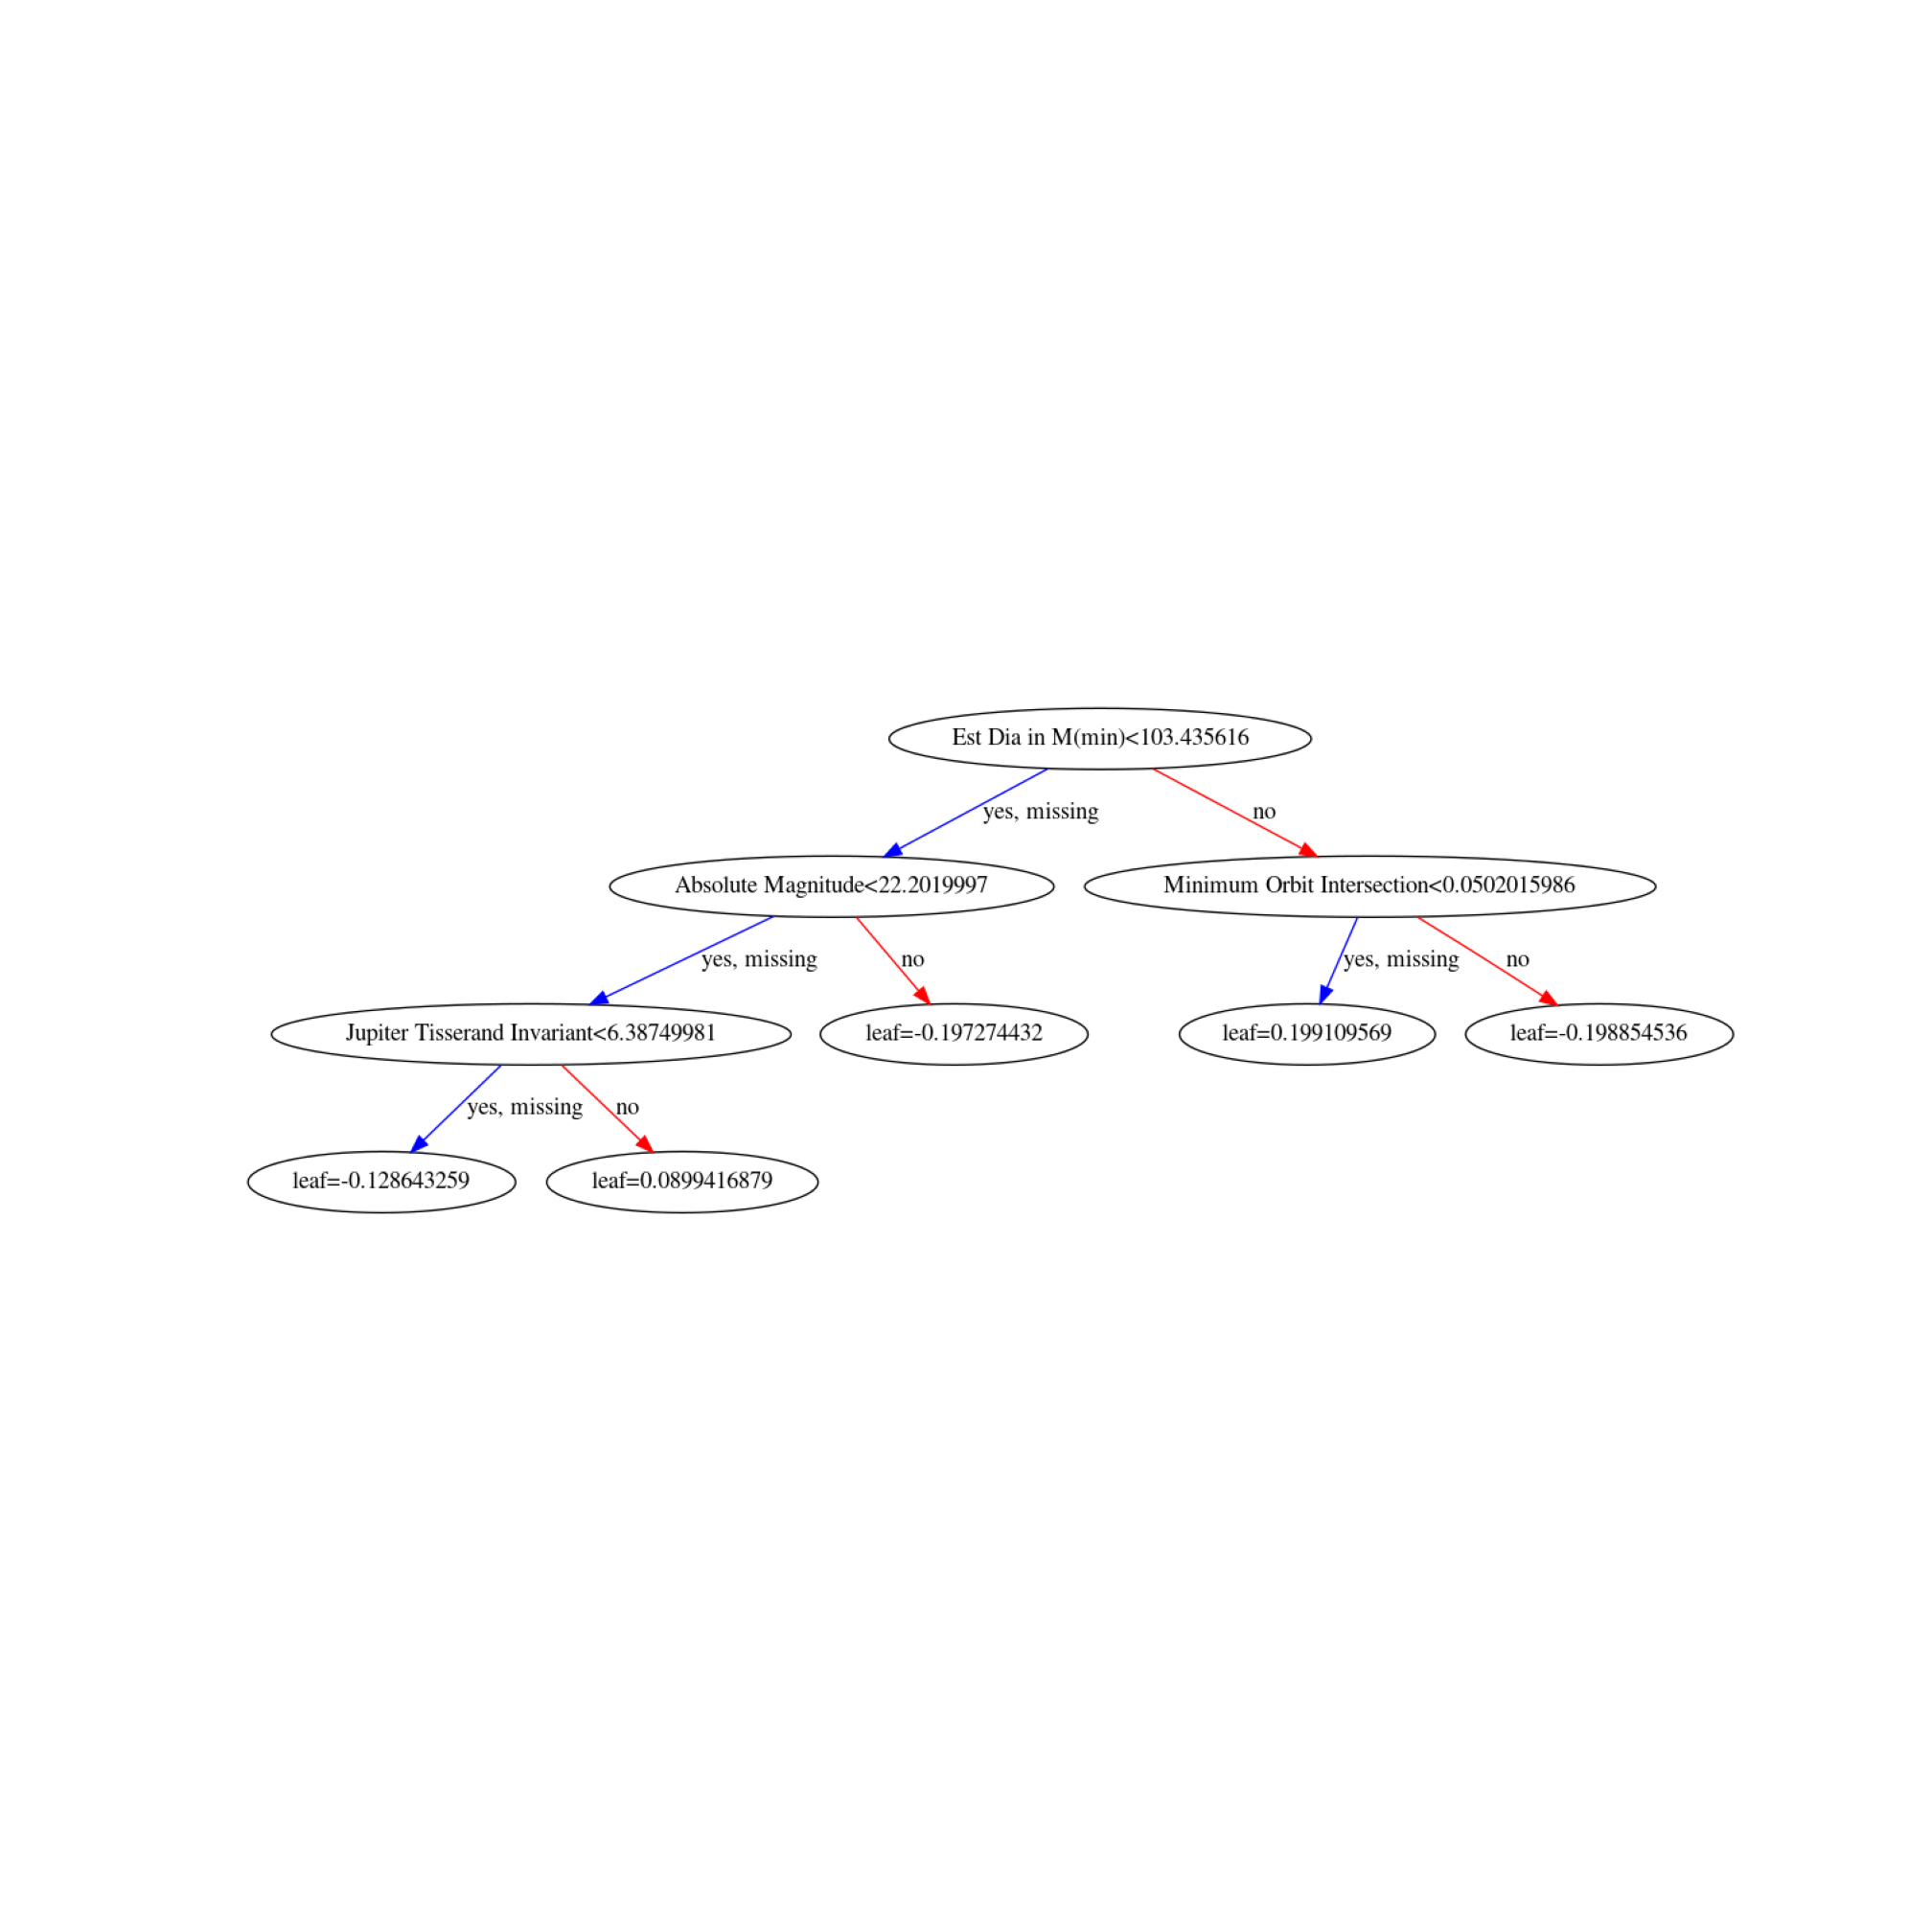

In [374]:
plt.rcParams['figure.figsize'] = [14, 14]

xgb.plot_tree(xcb_final, show_node_id = True)

plt.show()

### Plot importance of features

<IPython.core.display.Javascript object>


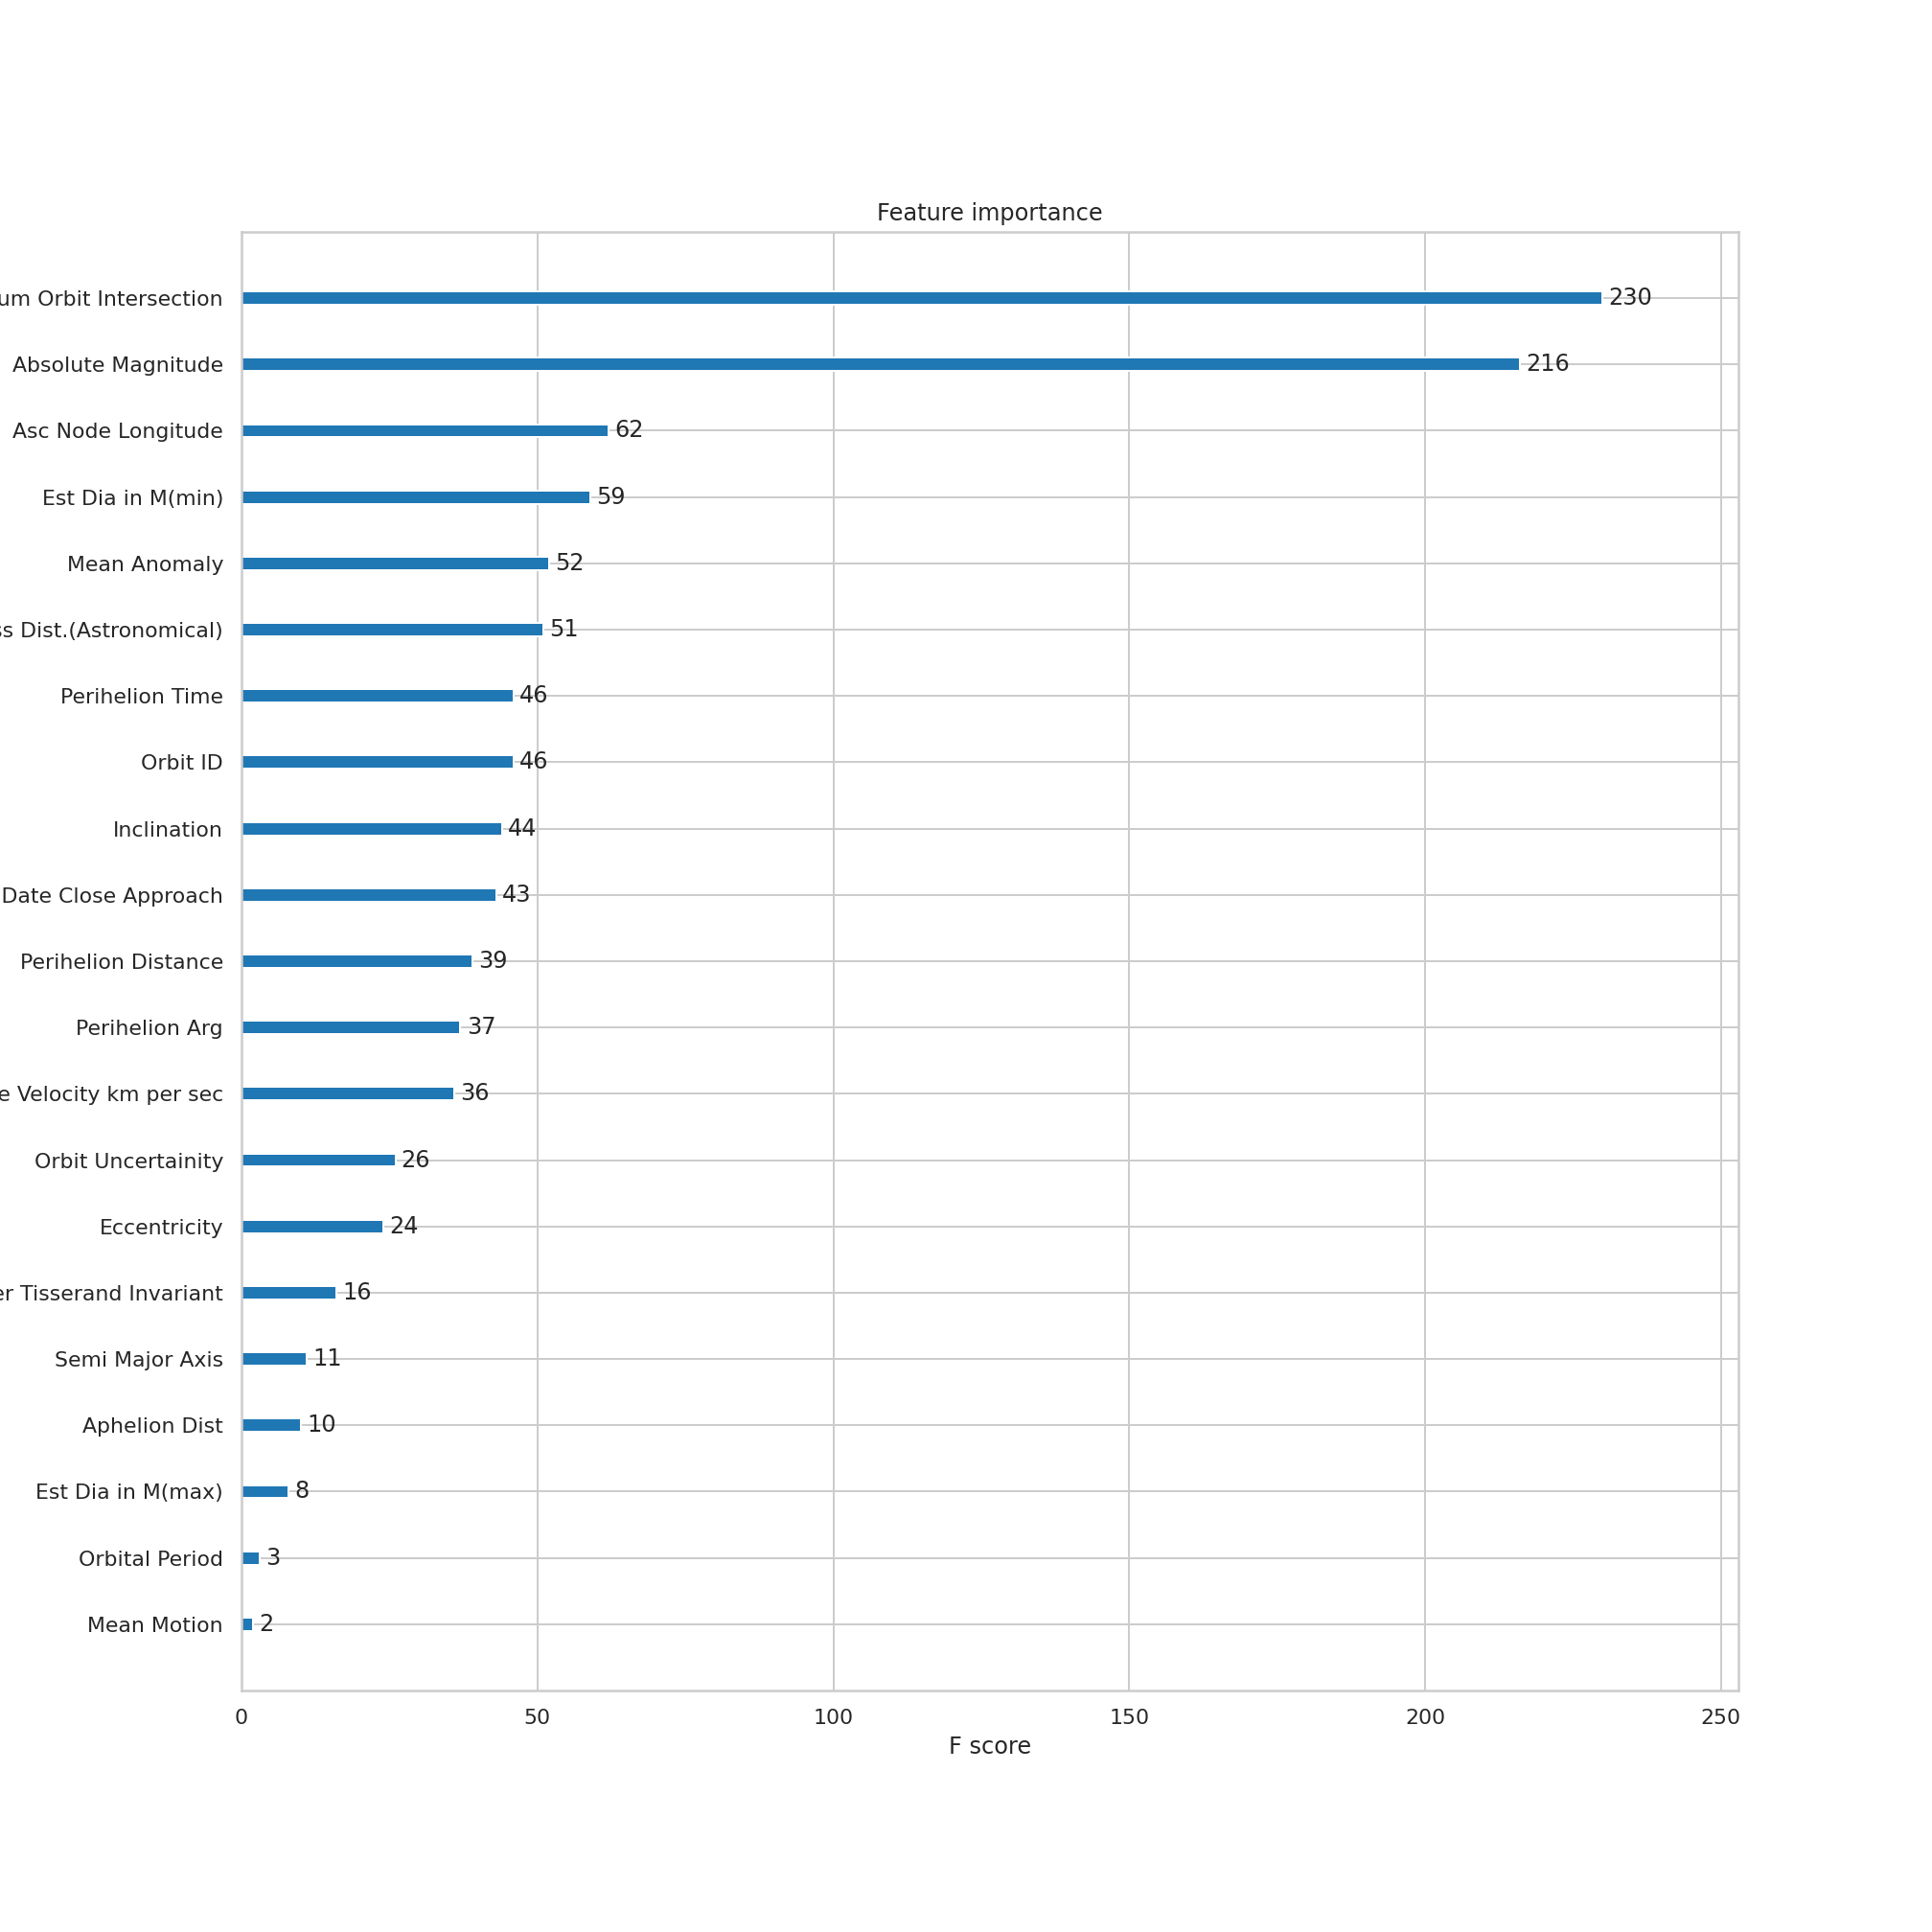

In [375]:
plt.rcParams['figure.figsize'] = [14, 14]

xgb.plot_importance(xcb_final)

plt.show()

### Plot confusion matrix

<IPython.core.display.Javascript object>


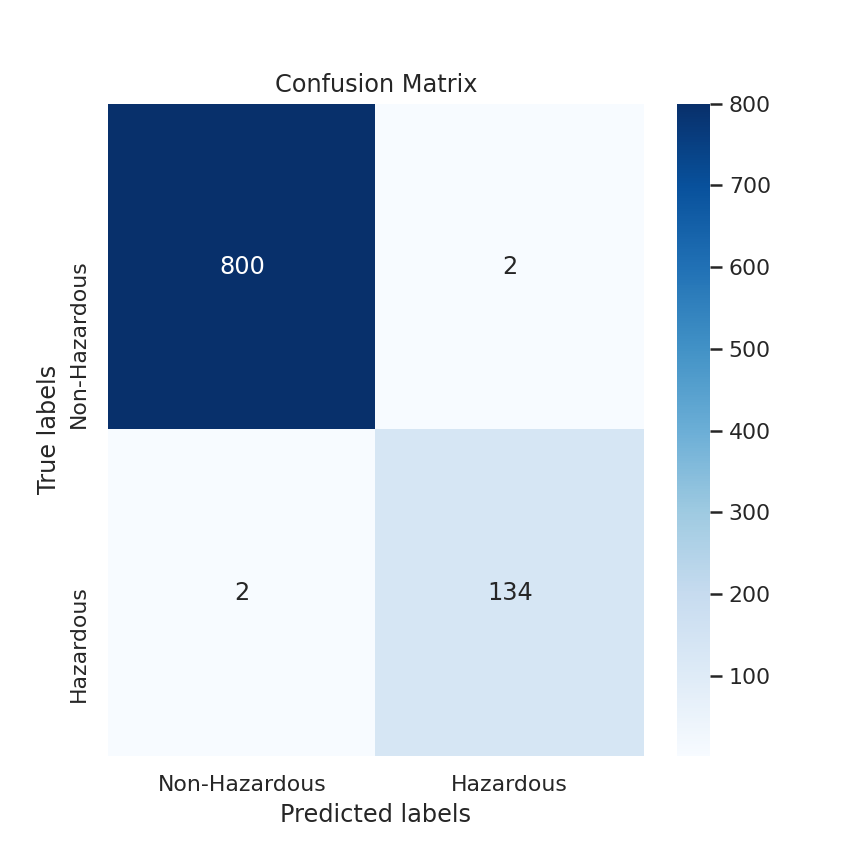

In [376]:
plt.rcParams['figure.figsize'] = [6, 6]

fig, ax = plt.subplots()

cm = confusion_matrix(y_test, y_hat_xgb)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d'); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']); ax.yaxis.set_ticklabels(['Non-Hazardous', 'Hazardous']);

plt.show()

In [377]:
xgb_score = cross_val_score(xcb_final, X_train, y_train, cv=kfold, scoring='f1_weighted')
xgb_scores = xgb_score.mean()
xgb_scores

0.9952092216602939